#Mount the Google Drive 
This code will mount the user's Google Drive into directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Data Preprocessing and Training 
The first  part of the code is to load the pretrained model of VGG_16 and modify it to meet our requirement.
1. add dropout layers and change the number of ckass to 7 *
2. set the trainable of first 4 block to false so that we only train the last convolutional block and fully connected block
Then the model is compiled in the model definition

The second part is to load the training and validation images from the directory
The data is being resize to 224 by 224 images, and the images are standardized by:
1. rescale each pixel from 0-255 to 0-1
2. center the mean to 0
3. divide each pixel by their standard deviation 
The data is automatically labeled to 7 classes in alphabetical order in  corresponding number from 0 to 6

The third part is to form the training
1. we can set the training definition and parameters
2. we will use save the weights to save the weights after training

The last part is to plot the training /validation accuracy/loss vs epochs


In [ ]:
import numpy as np
import skimage
from keras.applications import vgg16

from keras.preprocessing.image import ImageDataGenerator
from keras import models 
from keras.layers import ZeroPadding2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
#from keras.layers import GlobalMaxPooling2D
#from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#The directory of train and validation data
dir_train = '/content/drive/My Drive/train'
dir_validation = '/content/drive/My Drive/validation'



x = models.Sequential()

model = vgg16.VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3), pooling='max', classes=1000)
model.layers.pop()
for layer in model.layers[:-2]:
  x.add(layer)

for layer in model.layers[-2:]:
  x.add(layer)
  x.add(Dropout(0.5))

x.add(Dense(7, activation='softmax'))
for layer in x.layers[:-10]:
    layer.trainable = False
 

for layer in x.layers[-10:]:
  print layer
#if you have pretrained weights you should uncomment the next line
#x.load_weights('/content/drive/My Drive/emotion_recognition_complete.h5')

x.compile(loss = 'categorical_crossentropy',optimizer = SGD(lr = 0.001,decay=0.1, momentum=0.9, nesterov=True),metrics = ['acc'])
x.summary()




#rescale the image and perpare for dataset


train_datagen = ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True)
train_generator = train_datagen.flow_from_directory(dir_train,target_size=(224, 224),batch_size=128,class_mode='categorical',shuffle = True)
val_datagen = ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True)
val_generator =val_datagen.flow_from_directory(dir_validation,target_size =(224,224),batch_size = 32,class_mode ='categorical',shuffle = True)

history = x.fit_generator(
train_generator,
steps_per_epoch=120,
epochs=75,
validation_data=val_generator,
validation_steps=50)
x.save_weights('/content/drive/My Drive/emotion_recognition_complete_other.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Data Augmentation
This file will perform data augmentation. The original data is augmented by adding rotation, random noise(gaussian,poisson, and salt), and flip.
This file will classify the augmented image into the pre-created directories of classes and set every training image to png file

In [ ]:
import os, shutil, sys, time, re, glob
import numpy as np

from skimage import io
from skimage import transform ,util


#This function adds random noise
def AddRand(img,tp):
    
    if tp == 'gaussian':
       return util.random_noise(img,mode ='gaussian')
    elif tp == 'poisson':
         return util.random_noise(img,mode ='poisson')
    elif tp =='salt':
         return util.random_noise(img,mode ='salt')
   
    else:
         return img

#This function adds flip
def AddFlip(img,isFilp):
    if isFlip:
       return np.fliplr(img)
    else:
       return img
#This function adds rotation
def AddRot(img,ang):
    if(ang !=0):
       return transform.rotate(img,ang)
    else:
       return img
      
# This function returns the label of the image     
def cl_getter(filename):
    fn = filename.split('/')[-1]
    fn = fn.split('.')[1]
    fn = fn[0:2]
    print fn
    return fn


dir_train = '/content/drive/My Drive/train'
filenames = glob.glob(dir_train+'/*.png') + glob.glob(dir_train+'/*.tiff')
angle = [0,10,20,30,40,50]
isFlips =[True,False]
tps = ['gaussian','poisson','salt','else']
for filename in filenames:
    org_img = io.imread(filename)
    ct = 0
    for ang in angle:
        for tp in tps:
            for isFlip in isFlips:
               img_aug = AddFlip(AddRand(AddRot(org_img,ang),tp),isFlip)
               fn = filename.split('/')[-1]
               fn = fn.split('.')[0] +'.'+ fn.split('.')[1]+str('.')+str(ct) +'.png'
               ct = ct+1
               dir_save = os.path.join(dir_train,cl_getter(filename),fn)
               io.imsave(dir_save,img_aug)
               print 'complete 1 image'
    
    

#Randomly select the image to form training dataset
This file will randomly select the images from each class and save them in the training dataset, and each class of training data will contain about 2000-2200 images.
We can change the parameter to form validation and testing dataset.

In [ ]:
import os
import glob
from skimage import io
emotions =['HA','SA','SU','DI','AN','NE','FE']
for emotion in emotions:
    file_dir = '/content/drive/My Drive/train_bank/' + emotion +'/*.png'
    filelist = glob.glob(file_dir)
    print emotion+'/'+str(len(filelist))
    if emotion == 'SA' or emotion == 'FE':
      for i in range(len(filelist)):
       
           fn = filelist[i].split('/')[-1]
           fn = '/content/drive/My Drive/validation_2/' + emotion +'/' + fn
           img = io.imread(filelist[i])
           io.imsave(fn,img)
           print 'complete 1 image'
    
    elif emotion == 'HA' or emotion =='SU':
      for i in range(len(filelist)):
        if i%2 ==0:
          fn = filelist[i].split('/')[-1]
          fn = '/content/drive/My Drive/validation_2/' + emotion +'/' + fn
          img = io.imread(filelist[i])
          io.imsave(fn,img)
          print 'complete 1 image'
          
    elif emotion =='DI' or emotion == 'AN':
      for i in range(len(filelist)):
        if i%3 != 0:
          fn = filelist[i].split('/')[-1]
          fn = '/content/drive/My Drive/validation_2/' + emotion +'/' + fn
          img = io.imread(filelist[i])
          io.imsave(fn,img)
          print 'complete 1 image'
    
    elif emotion =='NE':
      for i in range(len(filelist)):
        if i%12 == 0:
          fn = filelist[i].split('/')[-1]
          fn = '/content/drive/My Drive/validation_2/' + emotion +'/' + fn
          img = io.imread(filelist[i])
          io.imsave(fn,img)
          print 'complete 1 image'
          
        

#Test Code
This part of code will test or predict the given image with or without label
This part of code first has to load the model and weights 
This test has 3 modes: number, confusion matrix, and unlabeled
1. label
It will automatically generate the accuracy and loss 
2. unlabel
It will print out the predicted label and file name.

W0915 06:05:29.717405 140133467068288 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python2.7/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


/content/drive/My Drive/CKP_complete/S005_001_00000001_crop1.NE.png
AN
[[7.4471498e-01 2.7686037e-04 5.0202962e-05 1.8217297e-05 2.5174731e-01
  3.1627361e-03 2.9657056e-05]]
/content/drive/My Drive/CKP_complete/S005_001_00000011_crop1.DI.png
DI
[[4.0171381e-02 9.5764554e-01 6.3503126e-06 1.5157621e-04 9.6144306e-04
  1.0634600e-03 2.8279527e-07]]
/content/drive/My Drive/CKP_complete/S010_003_00000001_crop1.NE.png
AN
[[6.2277591e-01 9.0415840e-04 1.8287284e-04 1.6825044e-05 3.4674785e-01
  2.9330280e-02 4.2100037e-05]]
/content/drive/My Drive/CKP_complete/S010_002_00000014_crop1.SU.png
SU
[[4.4924423e-07 1.4570506e-07 1.5479051e-04 1.5483747e-06 2.8098701e-05
  3.3654607e-05 9.9978131e-01]]
/content/drive/My Drive/CKP_complete/S010_001_00000001_crop1.NE.png
NE
[[3.9853063e-01 2.5499088e-03 2.6678469e-04 1.1866621e-04 5.8044046e-01
  1.8040800e-02 5.2737218e-05]]
/content/drive/My Drive/CKP_complete/S010_002_00000001_crop1.NE.png
AN
[[6.0737062e-01 1.1888490e-03 2.1532846e-04 9.7938704e

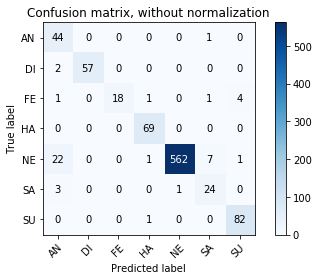

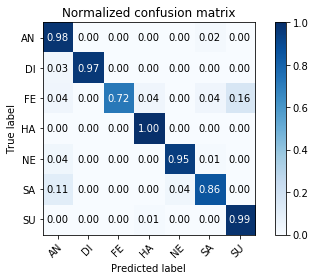

In [ ]:
import numpy as np
import skimage
import cv2
from keras.applications import vgg16
import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.metrics import top_k_categorical_accuracy
from keras import models 
from keras.layers import ZeroPadding2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
#from keras.layers import GlobalMaxPooling2D
#from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#===============================================================

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



#========================================================================



#The directory of train and validation data

test_dir = '/content/drive/My Drive/unlabeled_images'
o_dir =  '/content/drive/My Drive/CKP_complete'

mode = 'confused_matrix'
x = models.Sequential()

model = vgg16.VGG16(include_top=True, weights='imagenet', input_shape=(224,224,3), pooling='max', classes=1000)
model.layers.pop()
for layer in model.layers[:-2]:
  x.add(layer)

for layer in model.layers[-2:]:
    x.add(layer)
    x.add(Dropout(0.5))

x.add(Dense(7, activation='softmax'))
for layer in x.layers[:-10]:
    layer.trainable = False
 


x.load_weights('/content/drive/My Drive/emotion_recognition_complete2.h5')

x.compile(loss = 'categorical_crossentropy',optimizer = SGD(lr = 0.001,decay=0.1, momentum=0.9, nesterov=True),metrics = ['acc'])
test_datagen = ImageDataGenerator(1./255,samplewise_center=True,samplewise_std_normalization=True)
if mode == 'number':
    
    test_generator = test_datagen.flow_from_directory(test_dir,target_size=(224, 224),batch_size=1,class_mode='categorical',shuffle = False)
    print len(test_generator)
    test_loss,test_acc = x.evaluate_generator(test_generator, steps=len(test_generator))
    test_prob = x.predict_generator(test_generator,steps = len(test_generator))
    print "Loss of the test:"
    print test_loss
    print "Accuracy of the test:"
    print test_acc
    
    print "==== predictions complete ===="
elif mode == 'confused_matrix':
 
  imglist = glob.glob(o_dir+"/*.png") 
  labels = ['AN','DI','FE','HA','NE','SA','SU']
  prob =[]
  result =[]
  y_truth =[]
  i =0
  for img in imglist:
     y_truth.append(labels.index(img.split('/')[-1].split('.')[1][0:2]))
     in_image = cv2.imread(img)
     in_image= cv2.resize(in_image,(224,224))
     image_arr = img_to_array(in_image)
     image_arr = np.reshape(image_arr,[1,224,224,3])

     test_generator = test_datagen.flow(image_arr,batch_size=1, shuffle=False, save_to_dir=test_dir,save_prefix="unlabeled"+str(i),save_format='png')
     i = i+1
     test_prob = x.predict_generator(test_generator,steps = 1) 
     
     prob.append(test_prob)
     result.append(test_prob.argmax())
     print img
     print labels[test_prob.argmax()]
     print test_prob
     print '========================'
  print "==== predictions complete ===="
  np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
  plot_confusion_matrix(y_truth, result, classes=labels,title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
  plot_confusion_matrix(y_truth, result, labels, normalize=True,title='Normalized confusion matrix')

  plt.show()  

elif mode == 'unlabeled':
  imglist = glob.glob(o_dir+"/*.png") 
  labels = ['AN','DI','FE','HA','NE','SA','SU']
  prob =[]
  result =[]
  
  i =0
  for img in imglist:
    
     in_image = cv2.imread(img)
     in_image= cv2.resize(in_image,(224,224))
     image_arr = img_to_array(in_image)
     image_arr = np.reshape(image_arr,[1,224,224,3])

     test_generator = test_datagen.flow(image_arr,batch_size=1, shuffle=False, save_to_dir=test_dir,save_prefix="unlabeled"+str(i),save_format='png')
     i = i+1
     test_prob = x.predict_generator(test_generator,steps = 1) 
     
     prob.append(test_prob)
     result.append(test_prob.argmax())
     print img
     print labels[test_prob.argmax()] 
     print '=============================='
  

  print "==== predictions complete ===="
else:
  print "Mode is incorrect!"
  print "You have to choose from number, confused_matrix, and unlabeled"

#Relabel the image
This part of the code will relabel the test image. The code will make copy of images from 7 classes and save them under one single directory with file name changed to the label of the test image. It will print out message when it completes one image. The saved images will be in format of png

In [ ]:
import os
import glob
from skimage import io
dir_test = '/content/drive/My Drive/new_test'
new_dir = '/content/drive/My Drive/final_test'

imglist = glob.glob(dir_test +'/*/*.png') + glob.glob(dir_test+'/*/*.tiff')
ct = 0
for img in imglist:
  x = io.imread(img)
  fn = img.split('/')[-1]
  label = fn.split('.')[1][0:2]
  save_dir = new_dir +'/'+label+str(ct)+'.png'
  io.imsave(save_dir,x)
  ct = ct +1
  print 'complete',img

complete /content/drive/My Drive/new_test/HA/S064_003_00000025_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S079_004_00000026_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S092_004_00000024_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S128_011_00000016_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S136_006_00000020_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S068_002_00000015_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S115_008_00000017_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S044_003_00000014_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S134_004_00000015_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S055_005_00000045_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S100_006_00000016_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S067_005_00000022_crop1.HA.png
complete /content/drive/My Drive/new_test/HA/S078_004_00000027_crop1.HA.png
complete /co

In [ ]:
import os
import glob
from skimage import io
new_dir = '/content/drive/My Drive/final_test'
imglist = glob.glob(new_dir +'/*.png')
print len(imglist)

204
